# Práctica: Traductor Inglés-Español

Beatriz Torreiro Mosquera

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string
import re
from numpy import array, argmax, random, take, arange
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Objetivo

El objetivo principal de esta práctica es la implementación de un traductor de inglés a español mediante la implementación de distintos algoritmos de Natural Language Processsing.

## 2. Lectura del conjunto de datos

Disponemos de un archivo 'spa.txt' que contiene frases en inglés y su traducción al español. En primer lugar, se lee el archivo utilizando la siguiente función.

In [0]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [0]:
data = read_text("/content/drive/My Drive/NLP/spa-eng/spa.txt")

In [6]:
data[:100]

'Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)\nGo.\tVete.\tC'

Observando los 100 primeros caracteres del archivo, se observa que a parte de contener el término en inglés y a continuación el término en español, también se incluye información no relevante 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)', que es necesario eliminar.

Antes de realizar la limpieza se deben modificar los datos para que cada frase traducida sea un elemento distinto. Esto se consigue a través de la siguiente función.

In [0]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [0]:
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [9]:
spa_eng[:2]

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)']],
      dtype='<U332')

Teniendo los datos organizamos de esta manera, la limpieza se limita a eliminar el tercer elemento de cada array.

In [0]:
spa_eng = spa_eng[:,:2]

In [11]:
spa_eng[:5]

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ['Go.', 'Váyase.'],
       ['Hi.', 'Hola.']], dtype='<U332')

## 3. Pre-procesamiento del texto

Ahora que ya tenemos información relevante en el array, es hora de limpiarla.

- Eliminamos los símbolos de puntuación.

In [0]:
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [13]:
spa_eng[:5]

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ['Go', 'Váyase'],
       ['Hi', 'Hola']], dtype='<U332')

 - Transformamos todas las palabras a minúsculas.

In [0]:
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()

In [15]:
spa_eng[:5]

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ['go', 'váyase'],
       ['hi', 'hola']], dtype='<U332')

 - Nos quedamos con una parte de los datos

Por limitaciones derivadas de la falta de recursos de computación, es necesario trabajar solamente con una fracción de las frases. Se va a trabajar con la mitad de las frases proporcionadas.

In [16]:
len(spa_eng)

122936

In [0]:
import random
spa_eng_limited = random.sample(list(spa_eng),int(len(spa_eng)*0.5))

In [0]:
spa_eng_limited = array(spa_eng_limited)

In [19]:
len(spa_eng_limited)

61468

 - Conversión a secuencias númericas

Para alimentar nuestros datos en un modelo Seq2Seq, tendremos que convertir tanto las frases de entrada como las de salida en secuencias númericas de longitud fija. Antes de eso, visualicemos la longitud de las oraciones.

In [0]:
eng_l = []
spa_l = []

for i in spa_eng_limited[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng_limited[:,1]:
    spa_l.append(len(i.split()))

In [21]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print('Lontigud máxima inglés: ' + str(max(length_df.eng)))
print('Longitud máxima español: ' + str(max(length_df.spa)))

Lontigud máxima inglés: 47
Longitud máxima español: 53


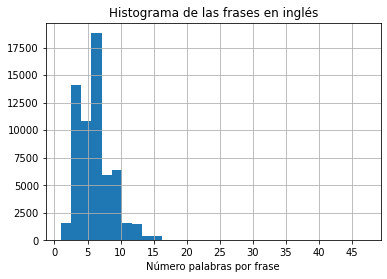

In [22]:
length_df.eng.hist(bins = 30)
plt.xticks(arange(0, 50, step=5))
plt.title('Histograma de las frases en inglés')
plt.xlabel('Número palabras por frase')
plt.show()

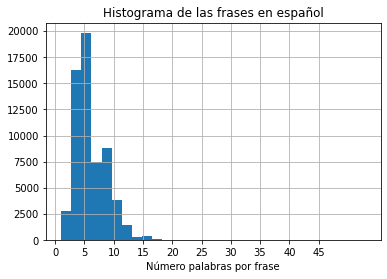

In [23]:
length_df.spa.hist(bins =30)
plt.xticks(arange(0, 50, step=5))
plt.title('Histograma de las frases en español')
plt.xlabel('Número palabras por frase')
plt.show()

Mirando los histogramas anteriores, se puede inferir que hay más frases con menos de 5 palabras en castellano que en inglés. Además, el número de palabras por frase más frecuente en español es 5 y en inglés es 7. En ambos casos, es poco frecuente encontrar frases con más de 20 palabras.

A continuación, vectorizamos los datos usando la librería de Keras Tokenizer() para obtener secuencias numércias a partir de cada una de las frases. Por último, se ajusta la longitud de todas las secuencias para que sea la mismas añadiendo un padding de ceros al final de las que lo requieran.

In [0]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [25]:
eng_tokenizer = tokenization(spa_eng_limited[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 10
print('Tamaño del vocabulario inglés: %d' % eng_vocab_size)

Tamaño del vocabulario inglés: 10748


In [26]:
spa_tokenizer = tokenization(spa_eng_limited[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 10
print('Tamaño del vocabulario español: %d' % spa_vocab_size)

Tamaño del vocabulario español: 20191


In [0]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    #print(seq)
    print(len(seq))
    return seq

## 4. Primer modelo: SimpleRNN

El primer algoritmo que se va a usar es el Simple RNN, ya que es el más sencillo de los estudiados. El principal problema de este algoritmo es que no se puede utilizar para procesar frases largas.

En primer lugar, se divide el conjunto de datos en training y test.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng_limited, test_size=0.2, random_state = 12)

In [29]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

49174
49174


In [30]:
print(trainX.shape)
print(trainY.shape)

(49174, 10)
(49174, 10)


In [31]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

12294
12294


In [32]:
print(testX.shape)
print(testY.shape)

(12294, 10)
(12294, 10)


In [0]:
units = 64
model_simple = Sequential()
model_simple.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_simple.add(SimpleRNN(units))
model_simple.add(RepeatVector(spa_length))
model_simple.add(SimpleRNN(units,return_sequences=True))
model_simple.add(Dense(spa_vocab_size, activation='softmax'))

model_simple.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')


In [34]:
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 64)            684672    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 64)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 64)            8256      
_________________________________________________________________
dense_1 (Dense)              (None, 10, 20210)         1313650   
Total params: 2,014,834
Trainable params: 2,014,834
Non-trainable params: 0
_________________________________________________________________


In [35]:
filename = 'model_simple.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_simple.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=20, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/20
39339/39339 [==============================] - 40s 1ms/step - loss: 4.4492 - val_loss: 3.9905

Epoch 00001: val_loss improved from inf to 3.99054, saving model to model_simple.h1
Epoch 2/20
39339/39339 [==============================] - 39s 994us/step - loss: 3.8534 - val_loss: 3.7511

Epoch 00002: val_loss improved from 3.99054 to 3.75108, saving model to model_simple.h1
Epoch 3/20
39339/39339 [==============================] - 39s 997us/step - loss: 3.6691 - val_loss: 3.6300

Epoch 00003: val_loss improved from 3.75108 to 3.63004, saving model to model_simple.h1
Epoch 4/20
39339/39339 [==============================] - 39s 997us/step - loss: 3.5292 - val_loss: 3.5159

Epoch 00004: val_loss improved from 3.63004 to 3.51592, saving model to model_simple.h1
Epoch 5/20
39339/39339 [==============================] - 39s 1000us/step - loss: 3.4273 - val_loss: 3.4721

Epoch 00005: val_loss improved from 3.51592 to 3.47211, saving m

Analicemos los valores de loss.

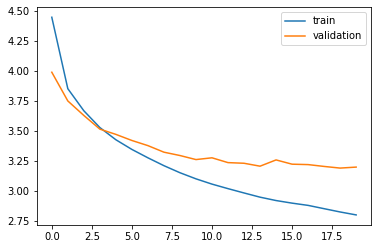

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Analizando los niveles de loss, se puede apreciar como las pérdidas de validación se quedan estancadas al redededor de 3.25 aproximadamente y no mejoran desde la séptima iteración.

A continuación, se analizan las predicciones realizadas por este modelo.

In [0]:
model_simple = load_model('model_simple.h1')
preds = model_simple.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [42]:
pred_df.sample(15)

,actual,predicted
7772,tom is a very interesting person,tom el la fue
3961,everyone is drunk,si el de
8125,they sat down,aquí
7554,i wanted to learn from the best,que todavía a de
2175,tom and mary seem a little confused,tom estoy mary estoy la
7388,i think that tom and mary are in trouble,que hay tom estoy es
9478,whos your favorite historical person,madre más mientras
8091,dont annoy me,está a una
11149,i think its time for me to call it a day,ella hay no de no él no él
4920,that man ate bread,de lo fue


Como se puede ver, ninguna de las predicciones anteriores son acertadas. Si recordamos, el algoritmo SimpleRNN funciona mejor cuando la longitud de las frases es pequeña. En la iteración anterior, se había configurado que el máximo número de palabras que podía haber en una frase era 10 palabras. Con el obejetivo de mejorar los resultados del traductor, se va a entrenar el mismo modelo, pero permitiendo que como máximo una frase tenga 3 palabras.

In [0]:
spa_length = 3
eng_length = 3

In [44]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

49174
49174


In [45]:
print(trainX.shape)
print(trainY.shape)

(49174, 3)
(49174, 3)


In [46]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

12294
12294


In [47]:
print(testX.shape)
print(testY.shape)

(12294, 3)
(12294, 3)


In [0]:
units = 64
model_simple_2 = Sequential()
model_simple_2.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_simple_2.add(SimpleRNN(units))
model_simple_2.add(RepeatVector(spa_length))
model_simple_2.add(SimpleRNN(units,return_sequences=True))
model_simple_2.add(Dense(spa_vocab_size, activation='softmax'))

model_simple_2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [49]:
filename = 'model_simple_2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_simple_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=20, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/20
39339/39339 [==============================] - 15s 388us/step - loss: 6.6416 - val_loss: 6.1641

Epoch 00001: val_loss improved from inf to 6.16411, saving model to model_simple_2.h1
Epoch 2/20
39339/39339 [==============================] - 15s 380us/step - loss: 5.8844 - val_loss: 5.7813

Epoch 00002: val_loss improved from 6.16411 to 5.78127, saving model to model_simple_2.h1
Epoch 3/20
39339/39339 [==============================] - 15s 374us/step - loss: 5.5389 - val_loss: 5.5490

Epoch 00003: val_loss improved from 5.78127 to 5.54902, saving model to model_simple_2.h1
Epoch 4/20
39339/39339 [==============================] - 15s 375us/step - loss: 5.2952 - val_loss: 5.3852

Epoch 00004: val_loss improved from 5.54902 to 5.38519, saving model to model_simple_2.h1
Epoch 5/20
39339/39339 [==============================] - 15s 373us/step - loss: 5.1014 - val_loss: 5.2384

Epoch 00005: val_loss improved from 5.38519 to 5.23841,

Analicemos los valores de loss a lo largo de las iteraciones.

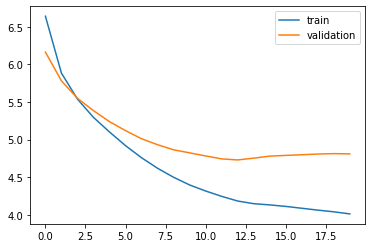

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Las curvas de pérdidas obtenidas con ese modelo son peores que las anteriores. Tarda un poco más en dejar de aprender, en este caso es la iteración número 12 aproximadamente, pero los valores de loss son mucho más elevados quedándose en torno a 5.

A continuación, se analizan las predicciones realizas por el modelo.

In [0]:
model_simple_2 = load_model('model_simple_2.h1')
preds = model_simple_2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [55]:
pred_df.sample(15)

,actual,predicted
5516,oranges contain a lot of vitamin c,es de casi
7900,this is how i usually cook fish,tan con mes
1527,youre the only one who can protect them,tiene se
168,i have some information for tom,a tom
10008,i found it by chance,esta para deja
2472,i cant believe you actually did something like that,libro me
11367,have you finished your homework already,más da
3221,try it once more,la ahora ¿qué
10882,would you like a piece of cake what kind of cake,ella no se
7100,tom is incompetent,tom el


Como se puede observar, este modelo tampoco es capaz de aprender, no traduce ninguna frase bien.

Viendo que la reducción de la longitud de las frases usadas para entrenar no ha mejorado el modelo, ni las frases cortas las aprende bien, se va a intentar mejorar el modelo añadiéndole más capas de recursividad a la red neuronal.

La estructura de le nuevo modelo es la siguiente:

In [0]:
units = 64
model_simple_3 = Sequential()
model_simple_3.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_simple_3.add(SimpleRNN(units))
model_simple_3.add(RepeatVector(spa_length))
model_simple_3.add(SimpleRNN(units,return_sequences=True))
model_simple_3.add(SimpleRNN(units,return_sequences=True))
model_simple_3.add(SimpleRNN(units,return_sequences=True))
model_simple_3.add(Dense(spa_vocab_size, activation='softmax'))

model_simple_3.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [57]:
model_simple_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3, 64)             684672    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 3, 64)             8256      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 3, 64)             8256      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 3, 64)             8256      
_________________________________________________________________
dense_3 (Dense)              (None, 3, 20210)         

In [58]:
filename = 'model_simple_3.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_simple_3.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=20, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/20
39339/39339 [==============================] - 22s 548us/step - loss: 6.5339 - val_loss: 6.0874

Epoch 00001: val_loss improved from inf to 6.08744, saving model to model_simple_3.h1
Epoch 2/20
39339/39339 [==============================] - 19s 488us/step - loss: 5.8152 - val_loss: 5.7268

Epoch 00002: val_loss improved from 6.08744 to 5.72684, saving model to model_simple_3.h1
Epoch 3/20
39339/39339 [==============================] - 19s 478us/step - loss: 5.4661 - val_loss: 5.4781

Epoch 00003: val_loss improved from 5.72684 to 5.47805, saving model to model_simple_3.h1
Epoch 4/20
39339/39339 [==============================] - 19s 476us/step - loss: 5.2047 - val_loss: 5.3200

Epoch 00004: val_loss improved from 5.47805 to 5.32000, saving model to model_simple_3.h1
Epoch 5/20
39339/39339 [==============================] - 19s 481us/step - loss: 4.9955 - val_loss: 5.1914

Epoch 00005: val_loss improved from 5.32000 to 5.19142,

Analizamos las curvas de pérdida de el nuevo modelo:

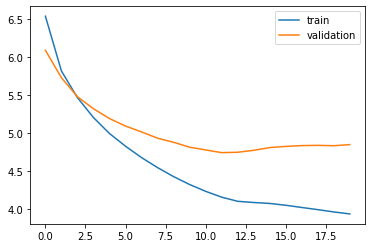

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Las curvas de pérdidas siguen sin mejorar.

A continuación, se analizan las predicciones realizas por el modelo.

In [0]:
model_simple_3 = load_model('model_simple_3.h1')
preds = model_simple_3.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [63]:
pred_df.sample(15)

,actual,predicted
2965,may i speak to you in private,no pero gran
5714,why did tom quit his job,ella mary tom
11883,could i have a piece of cheesecake,después un estamos
9691,theres no need to be gentle,hacer las
6581,are you bored,le no estado
10575,i wasnt able to do everything i wanted to do,qué a él
2388,that isnt going to happen,era a ¿por
1251,go wait outside,a tan hija
4517,where are you going in such a hurry weve got plenty of time so drive safely,de ser hecho
4582,tom often goes shopping alone,del de ¿cómo


Tras cambiar varios parámetros del modelo y no observar mejora alguna en las predicciones realizadas, se puede concluir que el algortimo SimpleRNN no es lo suficientemente potente como para realizar buenas predicciones con el conjunto de datos de entrenamiento proporcionado.

## Segundo modelo: LSTM

El algoritmo Long Short Term Memory (LSTM) permite el transporte de información durante más iteraciones, de ahí el nombre. Básicamente lo que hace es guardar información para más adelante, evitando que la información más antigua se vaya perdiendo a medida que avanza el proceso de aprendizaje

A continuación, se entrena un primer modelo utilizando este algoritmo, volviendo al valor original de número de palabras por frase.

In [0]:
spa_length = 10
eng_length = 10

In [65]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

49174
49174


In [66]:
print(trainX.shape)
print(trainY.shape)

(49174, 10)
(49174, 10)


In [67]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

12294
12294


In [68]:
print(testX.shape)
print(testY.shape)

(12294, 10)
(12294, 10)


In [0]:
units = 64
model_lstm = Sequential()
model_lstm.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_lstm.add(LSTM(units))
model_lstm.add(RepeatVector(spa_length))
model_lstm.add(LSTM(units,return_sequences=True))
model_lstm.add(Dense(spa_vocab_size, activation='softmax'))

model_lstm.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [70]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 64)            684672    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dense_4 (Dense)              (None, 10, 20210)         1313650   
Total params: 2,064,370
Trainable params: 2,064,370
Non-trainable params: 0
_________________________________________________________________


In [71]:
filename = 'model_lstm.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_lstm.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=20, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/20
39339/39339 [==============================] - 59s 1ms/step - loss: 4.5451 - val_loss: 3.9775

Epoch 00001: val_loss improved from inf to 3.97749, saving model to model_lstm.h1
Epoch 2/20
39339/39339 [==============================] - 58s 1ms/step - loss: 3.9034 - val_loss: 3.8204

Epoch 00002: val_loss improved from 3.97749 to 3.82035, saving model to model_lstm.h1
Epoch 3/20
39339/39339 [==============================] - 58s 1ms/step - loss: 3.7583 - val_loss: 3.7317

Epoch 00003: val_loss improved from 3.82035 to 3.73165, saving model to model_lstm.h1
Epoch 4/20
39339/39339 [==============================] - 58s 1ms/step - loss: 3.6563 - val_loss: 3.6413

Epoch 00004: val_loss improved from 3.73165 to 3.64133, saving model to model_lstm.h1
Epoch 5/20
39339/39339 [==============================] - 58s 1ms/step - loss: 3.5470 - val_loss: 3.5373

Epoch 00005: val_loss improved from 3.64133 to 3.53732, saving model to model_lst

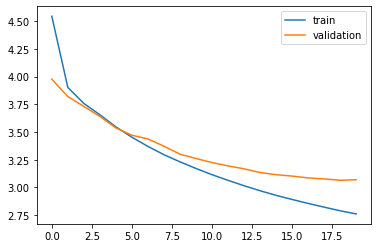

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Se puede apreciar que las curvas de pérdidas se han reducido un poco en comparación con los niveles del modelo anterior. Además parece que la curva de validación todavía no se ha llegado a aplanar del todo, por lo que se podrían meter más iteraciones para ver cómo seguiría el progreso.

In [0]:
model_lstm = load_model('model_lstm.h1')
preds = model_lstm.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [76]:
pred_df.sample(15)

,actual,predicted
6081,thats our secret,sin el
2200,tom thought this was a good idea,tom ver me lo la
10451,the couple separated never to see each other again,de hablar a
10960,why are we whispering,ellos le no tenía
9214,nobody talked about the movie,mucho de te a de
4745,you havent given me any yet,que siempre una
4449,who cheered,mañana
613,people used to travel on foot,ya estar a
5316,its very important,si la fue
2550,id like to go with you but im broke,que tu a los


Las predicciones siguen sin ser acertadas.

Se va a intentar mejorar las predicciones del modelo incrementando la longitud de las frases que se usan para entrenar y aumentando el número de iteraciones. El aumento de número de palabras permitirá a LSTM sacar más provecho de su capacidad para retener información a lo largo de las iteraciones.

In [0]:
spa_length = 20
eng_length = 20

In [30]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

49174
49174


In [31]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

12294
12294


In [0]:
units = 64
model_lstm_2 = Sequential()
model_lstm_2.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_lstm_2.add(LSTM(units))
model_lstm_2.add(RepeatVector(spa_length))
model_lstm_2.add(LSTM(units,return_sequences=True))
model_lstm_2.add(Dense(spa_vocab_size, activation='softmax'))

model_lstm_2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [81]:
filename = 'model_lstm_2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_lstm_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=40, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/40
39339/39339 [==============================] - 111s 3ms/step - loss: 2.6068 - val_loss: 2.0545

Epoch 00001: val_loss improved from inf to 2.05455, saving model to model_lstm_2.h1
Epoch 2/40
39339/39339 [==============================] - 107s 3ms/step - loss: 2.0324 - val_loss: 1.9804

Epoch 00002: val_loss improved from 2.05455 to 1.98036, saving model to model_lstm_2.h1
Epoch 3/40
39339/39339 [==============================] - 106s 3ms/step - loss: 1.9544 - val_loss: 1.9448

Epoch 00003: val_loss improved from 1.98036 to 1.94483, saving model to model_lstm_2.h1
Epoch 4/40
39339/39339 [==============================] - 107s 3ms/step - loss: 1.9056 - val_loss: 1.8997

Epoch 00004: val_loss improved from 1.94483 to 1.89973, saving model to model_lstm_2.h1
Epoch 5/40
39339/39339 [==============================] - 106s 3ms/step - loss: 1.8526 - val_loss: 1.8361

Epoch 00005: val_loss improved from 1.89973 to 1.83614, saving model

Se analizan las curvas de pérdidas a lo largo de las iteraciones.

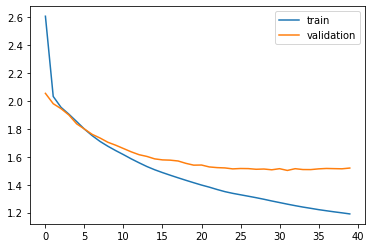

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Como se puede observar en las curvas anteriores, los valores de pérdidas han disminuido considerablemente en comparación con los obtenidos anteriormente. Sin embargo, los valores de pérdidas de validación se quedan estancados alrededor de 1.5. Claramente, el aumento del número de palabras por frase y el aumento del número de iteraciones han ayudado a mejorar el modelo.

A continuación, se comprobará si dicha mejoría se traduce en mejores predicciones.

In [0]:
model_lstm_2 = load_model('model_lstm_2.h1')
preds = model_lstm_2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [86]:
pred_df.sample(15)

,actual,predicted
9583,are you happy now,le no niño
10863,i assumed tom had told you i would be here,que ver tom me que él a
11351,why dont you answer,ellos está no estaba
5119,nature is full of mystery,verdad el es
5418,it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rath...,de eres un a
8047,has anybody else seen this,los no persona
4667,that person is like me,por el todo que
2462,tom isnt a good cook,tom muy la puede
3019,theyre washing their hands,aquí le
10484,what were you guys talking about,ella esto todos


A pesar de haber conseguido reducir considerablemente, las pérdidas del modelo, todavía no se pueden ver los efectos en las predicciones realizadas.

A continuación, se añaden más capas al modelo, esperando que los resultados de predicción mejoren. No tiene mucho sentido aumentar el número máximo de palabras por frase, ya que se nos fijamos en los histogramas calculados al principio, prácticamente todas las frases tienen menos de 20 palabras.

In [0]:
units = 64
model_lstm_3 = Sequential()
model_lstm_3.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_lstm_3.add(LSTM(units))
model_lstm_3.add(RepeatVector(spa_length))
model_lstm_3.add(LSTM(units,return_sequences=True))
model_lstm_3.add(LSTM(units,return_sequences=True))
model_lstm_3.add(LSTM(units,return_sequences=True))
model_lstm_3.add(LSTM(units,return_sequences=True))
model_lstm_3.add(Dense(spa_vocab_size, activation='softmax'))

model_lstm_3.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [88]:
model_lstm_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 64)            684672    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 20, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
lstm_8 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
lstm_9 (LSTM)                (None, 20, 64)           

In [89]:
filename = 'model_lstm_3.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_lstm_3.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=40, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/40
39339/39339 [==============================] - 188s 5ms/step - loss: 2.6073 - val_loss: 2.0308

Epoch 00001: val_loss improved from inf to 2.03076, saving model to model_lstm_3.h1
Epoch 2/40
39339/39339 [==============================] - 185s 5ms/step - loss: 2.0223 - val_loss: 1.9911

Epoch 00002: val_loss improved from 2.03076 to 1.99108, saving model to model_lstm_3.h1
Epoch 3/40
39339/39339 [==============================] - 185s 5ms/step - loss: 1.9937 - val_loss: 2.0031

Epoch 00003: val_loss did not improve from 1.99108
Epoch 4/40
39339/39339 [==============================] - 185s 5ms/step - loss: 1.9738 - val_loss: 1.9642

Epoch 00004: val_loss improved from 1.99108 to 1.96421, saving model to model_lstm_3.h1
Epoch 5/40
39339/39339 [==============================] - 184s 5ms/step - loss: 1.9331 - val_loss: 1.9248

Epoch 00005: val_loss improved from 1.96421 to 1.92485, saving model to model_lstm_3.h1
Epoch 6/40
39339/

Se analizan las curvas de pérdidas a lo largo del tiempo.

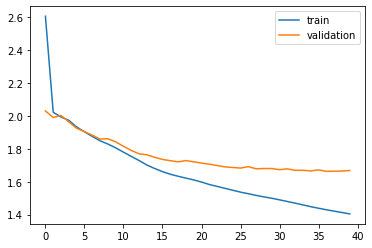

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Aumentando la complejidad de la red lo único que se ha conseguido es aumentar el overfitting, que ya existía.

In [0]:
model_lstm_3 = load_model('model_lstm_3.h1')
preds = model_lstm_3.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [94]:
pred_df.sample(15)

,actual,predicted
6257,youre an idiot,sé la más
8175,can i tag along,tiene que solo se
9618,i wont tell anybody else,que ni él a gusta
5056,im undressing,que no
6909,i hope you like me,que dejó no tiene
7872,hes the boy we spoke about the other day,en el la estás un estoy a de esa
7430,tom and mary are very old friends,tom estoy mary le la para habitación
5105,the painting looks great but you hung it a little crooked,de estar hacer de me el
2317,tensions were increasing,de un
7176,tom dressed himself quickly then ran out the door,tom cómo es de un estoy de es de


Los resultados siguen sin ser coherentes.

Para solucionar los problemas de overfitting, se va entrenar un tipo de modelo similar a LSTM, pero un poco más simple, los modelos GRU (Gated Recurrent Unit).

## Tercer modelo: GRU

Los modelos GRU son una variante de los modelos LSTM que reducen la complejidad del mismo reduciendo a dos el número de gates.

A continuación se prueba un primer modelo GRU sobre el conjunto de datos. Se mantiene el número de palabras máximo por frase en 20.

In [0]:
from keras.layers import GRU
units = 64
model_gru = Sequential()
model_gru.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_gru.add(GRU(units))
model_gru.add(RepeatVector(spa_length))
model_gru.add(GRU(units,return_sequences=True))
model_gru.add(Dense(spa_vocab_size, activation='softmax'))

model_gru.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [96]:
model_gru.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 64)            684672    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24768     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 20, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 64)            24768     
_________________________________________________________________
dense_7 (Dense)              (None, 20, 20210)         1313650   
Total params: 2,047,858
Trainable params: 2,047,858
Non-trainable params: 0
_________________________________________________________________


In [97]:
filename = 'model_gru.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_gru.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=40, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/40
39339/39339 [==============================] - 124s 3ms/step - loss: 2.5486 - val_loss: 2.0559

Epoch 00001: val_loss improved from inf to 2.05587, saving model to model_gru.h1
Epoch 2/40
39339/39339 [==============================] - 120s 3ms/step - loss: 2.0076 - val_loss: 1.9756

Epoch 00002: val_loss improved from 2.05587 to 1.97559, saving model to model_gru.h1
Epoch 3/40
39339/39339 [==============================] - 119s 3ms/step - loss: 1.9519 - val_loss: 1.9223

Epoch 00003: val_loss improved from 1.97559 to 1.92234, saving model to model_gru.h1
Epoch 4/40
39339/39339 [==============================] - 119s 3ms/step - loss: 1.8997 - val_loss: 1.8708

Epoch 00004: val_loss improved from 1.92234 to 1.87082, saving model to model_gru.h1
Epoch 5/40
39339/39339 [==============================] - 119s 3ms/step - loss: 1.8435 - val_loss: 1.8320

Epoch 00005: val_loss improved from 1.87082 to 1.83202, saving model to model_gr

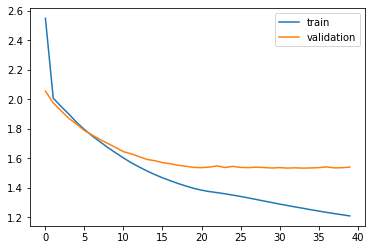

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Como ocurría con la segunda iteración del algoritmo LSTM, la validación se queda estancada en valores de pérdidas próximos a 1.5 . Además, cabe destacar que a partir de la iteración número 20 el modelo deja de apreder de una manera sana y se deja llevar por el overfitting.

In [0]:
model_gru = load_model('/content/drive/My Drive/NLP/model_gru.h1')
preds = model_gru.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [108]:
pred_df.sample(15)

,actual,predicted
11877,im an archaeologist,yo voy
5397,a sentence doesnt have to be long to be beautiful,la estar a las a la
8594,tom went on a camping trip with a friend,tom lo la un comida
3785,im with a client,yo la
4249,the king always wears a crown,de el nos la
1158,edison invented many useful things,francés estás francés un no
10928,a really bad thing happened to him,se lo la
11337,im supposed to talk to tom,que les a tom
11230,tom wants to know where youve hidden the key,tom quién a ese no en
9305,dont leave the windows open,está pensé de ahí


Las predicciones siguen sin ser muy acertadas.

Para solucionar los problemas descritos en este modelo, se va a crear un nuevo modelo un poco más complejo, añadiéndole alguna capa. Además, se van a reducir a 20 el número de epochs.

In [0]:
from keras.layers import GRU
units = 64
model_gru_2 = Sequential()
model_gru_2.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model_gru_2.add(GRU(units))
model_gru_2.add(RepeatVector(spa_length))
model_gru_2.add(GRU(units,return_sequences=True))
model_gru_2.add(GRU(units,return_sequences=True))
model_gru_2.add(GRU(units,return_sequences=True))
model_gru_2.add(Dense(spa_vocab_size, activation='softmax'))

model_gru_2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [33]:
model_gru_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 64)            687872    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24768     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 64)            24768     
_________________________________________________________________
gru_3 (GRU)                  (None, 20, 64)            24768     
_________________________________________________________________
gru_4 (GRU)                  (None, 20, 64)            24768     
_________________________________________________________________
dense_1 (Dense)              (None, 20, 20191)        

In [34]:
filename = 'model_gru_2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_gru_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=20, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Train on 39339 samples, validate on 9835 samples
Epoch 1/20
39339/39339 [==============================] - 106s 3ms/step - loss: 2.5085 - val_loss: 2.0188

Epoch 00001: val_loss improved from inf to 2.01877, saving model to model_gru_2.h1
Epoch 2/20
39339/39339 [==============================] - 101s 3ms/step - loss: 2.0151 - val_loss: 1.9957

Epoch 00002: val_loss improved from 2.01877 to 1.99569, saving model to model_gru_2.h1
Epoch 3/20
39339/39339 [==============================] - 99s 3ms/step - loss: 1.9888 - val_loss: 1.9988

Epoch 00003: val_loss did not improve from 1.99569
Epoch 4/20
39339/39339 [==============================] - 99s 3ms/step - loss: 1.9472 - val_loss: 1.9521

Epoch 00004: val_loss improved from 1.99569 to 1.95211, saving model to model_gru_2.h1
Epoch 5/20
39339/39339 [==============================] - 99s 3ms/step - loss: 1.9119 - val_loss: 1.9155

Epoch 00005: val_loss improved from 1.95211 to 1.91551, saving model to model_gru_2.h1
Epoch 6/20
39339/39339 [

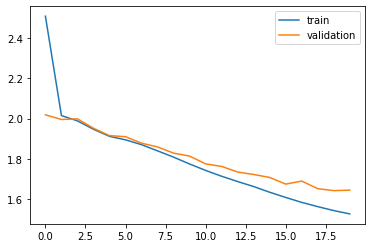

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Este nuevo modelo tiene, claramente, menos overfitting, pero los niveles de error en validación tan solo bajan hasta 1.7. De todos los modelos calculados este es el que tiene mejor compromiso entre nivel de pérdidas y overfitting.

In [0]:
model_gru_2 = load_model('model_gru_2.h1')
preds = model_gru_2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [45]:
pred_df.sample(15)

,actual,predicted
5696,i phoned mary but the line was busy,que alguien me él
3053,how many people are there in this office,casa ¿qué el no es una
2842,she advised him to listen to his doctor,en alguien su a de
4445,you are overworked,que los a de
3351,i looked around,que nadie por
7371,ill be home alone all night,que mucho a de
413,ill pick tom up in an hour,que del este a es de
6057,smoking isnt allowed in this restaurant,fue tu a una
11423,whats my room number,ella más una
11086,i lost another chance,que ha es


## Conclusión

Tras realizar varias iteraciones y probar 3 algoritmos distintos, no se ha conseguido crear ningún modelo capaz de crear unas predicciones acertadas. Parte del problema probablemente esté derivado de la necesidad de reducir el tamaño de vocabulario por limitaciones físicas de Google Colaboratory. Además no se ha podido jugar con el parámetro "batch_size" por limitaciones de memoria RAM.